# Setup

In [1]:
!git clone https://github.com/d4nst/RotNet.git
%cd /content/RotNet

Cloning into 'RotNet'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 157 (delta 2), reused 0 (delta 0), pack-reused 151
Receiving objects: 100% (157/157), 10.35 MiB | 25.17 MiB/s, done.
Resolving deltas: 100% (80/80), done.
/content/RotNet


In [2]:
!mkdir dataset
!mkdir models
%cd dataset
!gdown --id 1bUb09tvKL1BPZDxPcLCDm4K443rHjdyQ
!unzip -q barcode_rotnet.zip
!rm barcode_rotnet.zip
%cd ../

/content/RotNet/dataset
Downloading...
From: https://drive.google.com/uc?id=1bUb09tvKL1BPZDxPcLCDm4K443rHjdyQ
To: /content/RotNet/dataset/barcode_rotnet.zip
66.6MB [00:00, 86.9MB/s]
/content/RotNet


In [1]:
%cd /content/RotNet/
ROOT_DIR = '/content/RotNet/'

/content/RotNet


# Data preparation

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from keras.applications.imagenet_utils import preprocess_input

from utils import angle_error, RotNetDataGenerator

In [3]:
train_ratio = 0.8

#data barcode
barcode_path = '/content/RotNet/dataset/barcode'

if not os.path.exists(barcode_path):
  os.makedirs(barcode_path)

samples = [os.path.join(barcode_path, path) for path in os.listdir(barcode_path)]
np.random.shuffle(samples)
train_filenames, test_filenames = np.split(np.array(samples),
                                           [int(len(samples) * train_ratio)])

In [4]:
input_shape = (224, 224, 3)
batch_size = 32

In [5]:
val_generator = RotNetDataGenerator(test_filenames.tolist(),
                                    input_shape=input_shape,
                                    batch_size=batch_size,
                                    preprocess_func=preprocess_input,
                                    crop_center=True,
                                    crop_largest_rect=True)

# Load the Model

In [6]:
from google.colab import files

print('Upload RotNet barcode models you want to convert to TFLite:')
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded model file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Upload RotNet barcode models you want to convert to TFLite:


In [7]:
path_to_model = '/content/RotNet/rotnet_barcode_view_resnet50_v2.hdf5'  # replace with model filename

saved_model = tf.keras.models.load_model(path_to_model, 
                                         custom_objects={'angle_error': angle_error})

# Convert to TFLite

## Representative Data Generator

In [8]:
images = []

N = len(test_filenames)
for i in range(100):
    image = cv2.imread(test_filenames[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224),cv2.INTER_AREA)
    images.append(image)
images = np.asarray(images,dtype='float32')

In [9]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(images).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

## Config and Convert

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

In [11]:
tflite_model_quant = converter.convert()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmp7mph5wub/assets


In [12]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [13]:
import pathlib

tflite_models_dir = pathlib.Path(os.path.join(ROOT_DIR, "models/tflite/"))
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"barcode_model_quant_latency.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24983832

In [ ]:
#@title Download the model
from google.colab import files

#@markdown Enter a file path:
file_path = "/content/RotNet/models/tflite/barcode_model_quant_latency.tflite" #@param {type:"string"}
files.download(file_path)

# Batch testing TFLite Model

In [14]:
val_image_batch, val_label_batch = next(iter(val_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

In [15]:
from time import time
from utils import angle_error

TFLITE_MODEL = '/content/RotNet/models/tflite/barcode_model_quant_latency.tflite'

# Load quantized TFLite model
tflite_interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_MODEL)

# Learn about its input and output details
input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

# Resize input and output tensors to handle batch of 32 images
tflite_interpreter_quant.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter_quant.resize_tensor_input(output_details[0]['index'], (32, 360))
tflite_interpreter_quant.allocate_tensors()

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

# Run inference
tflite_interpreter_quant.set_tensor(input_details[0]['index'], np.array(val_image_batch, dtype=np.uint8))

start = time()
tflite_interpreter_quant.invoke()
exec_time = time() - start


tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
print("\nPrediction results shape:", tflite_q_model_predictions.shape)
acc = angle_error(true_label_ids, tflite_q_model_predictions)
print("Angle error: ", float(acc))
print("Time elapsed: ", exec_time)

== Input details ==
name: input_1
shape: [ 32 224 224   3]
type: <class 'numpy.uint8'>

== Output details ==
name: Identity
shape: [ 32 360]
type: <class 'numpy.uint8'>

Prediction results shape: (32, 360)
Angle error:  110.84375
Time elapsed:  377.4990780353546


# Single image testing

Angle: 188
Image shape: (224, 224, 3)


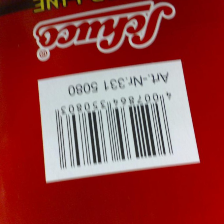

In [16]:
import cv2
import numpy as np
from utils import generate_rotated_image
from google.colab.patches import cv2_imshow


path_img = '/content/RotNet/dataset/barcode/'
list_test_image = os.listdir(path_img)
index = np.random.randint(len(list_test_image))

rotation_angle = np.random.randint(360)
test_image_path = os.path.join(path_img, list_test_image[index])

test_image = cv2.imread(test_image_path)

rotated_image = generate_rotated_image(
    test_image,
    rotation_angle,
    size=(224, 224),
    crop_center=True,
    crop_largest_rect=True,
)

rotated_image = np.asarray(rotated_image, dtype='uint8')

print("Angle:", rotation_angle)
print("Image shape:", rotated_image.shape)
cv2_imshow(rotated_image)

In [17]:
from time import time

copy_of_rotated_image = np.expand_dims(rotated_image, axis=0)

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
interpreter.resize_tensor_input(input_details[0]['index'], (1, 224, 224, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (1, 360))
interpreter.allocate_tensors()

# Run inference
interpreter.set_tensor(input_details[0]['index'], copy_of_rotated_image)

start = time()
interpreter.invoke()
exec_time = time() - start

img_angle_pred = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", img_angle_pred.shape)
print("Time elapsed: ", exec_time)

Prediction results shape: (1, 360)
Time elapsed:  11.850368022918701


10


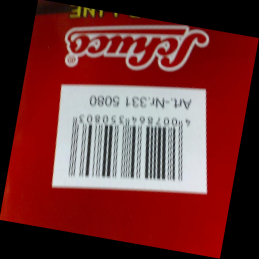

In [18]:
from utils import rotate

pred_angle = int(img_angle_pred.argmax(axis=-1))
restored_image = rotate(rotated_image, -pred_angle)
print(pred_angle)
cv2_imshow(restored_image)